## Installation of Required Packages

In [ ]:
!pip install scikit-image
!pip install pydot
!pip install keras-vggface
!pip install 'h5py==2.10.0'

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


## Imports

In [ ]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io
import skimage
from skimage.transform import rescale, resize
import pydot
import keras
from keras import backend as K
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *

from google.colab import drive
drive.mount('/content/drive')
print(tf.__version__)
print(keras.__version__)

TensorFlow 1.x selected.


Using TensorFlow backend.


Mounted at /content/drive
1.15.2
2.3.1


## Loading Dataset

In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/Deep_Project/dataset/train.zip' -d train
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/Deep_Project/dataset/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/Deep_Project/dataset/test-private.zip' -d test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
test_generator  = get_datagen('/content/test')
dev_generator    = get_datagen('/content/dev')
train_generator  = get_datagen('/content/train', True)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## Models

### Baseline Model

In [ ]:
epochs = 150
batch_size = 128
dropout_rate = 0.3
lr = 0.01
SGD_DECAY = 0.0001

In [ ]:
baseline_model = Sequential()
baseline_model.add(BatchNormalization(input_shape=(48,48,1)))
baseline_model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
baseline_model.add(BatchNormalization())
baseline_model.add(Dropout(0.2))
baseline_model.add(Conv2D(32, (3, 3), activation='relu',padding='same',name="conv2"))
baseline_model.add(BatchNormalization())
baseline_model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
baseline_model.add(Dropout(0.2))
baseline_model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv3"))
baseline_model.add(BatchNormalization())
baseline_model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
baseline_model.add(Dropout(0.2))
baseline_model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv4"))
baseline_model.add(BatchNormalization())
baseline_model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool4"))
baseline_model.add(Dropout(0.2))
baseline_model.add(Flatten())
baseline_model.add(Dense(1024, activation='relu',name='fc1'))
baseline_model.add(Dropout(dropout_rate))
baseline_model.add(BatchNormalization())
baseline_model.add(Dense(7, activation='softmax',name='fcsoftmax'))

sgd = SGD(lr=lr,momentum=0.9, decay=SGD_DECAY, nesterov=True)
baseline_model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
history = baseline_model.fit_generator( generator = train_generator, validation_data=dev_generator, epochs=epochs,  shuffle=True) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/150
248/248 [==============================] - 33s 132ms/step - loss: 1.9923 - acc: 0.2637 - val_loss: 1.6430 - val_acc: 0.3653

Epoch 00001: val_acc improved from -inf to 0.36528, saving model to /content/drive/My Drive/cs230 project/models/Baseline-weights-best.hdf5
Epoch 2/150
248/248 [==============================] - 29s 118ms/step - loss: 1.7753 - acc: 0.3219 - val_loss: 1.5590 - val_acc: 0.4099

Epoch 00002: val_acc improved from 0.36528 to 0.40986, saving model to /content/drive/My Drive/cs230 project/models/Baseline-weights-best.hdf5
Epoch 3/150
248/248 [==============================] - 30s 121ms/step - loss: 1.6891 - acc: 0.3553 - val_loss: 1.4688 - val_acc: 0.4313

Epoch 00003: val_acc improved from 0.40986 to 0.43132, saving model to /content/drive/My Drive/cs230 project/models/Baseline-weights-best.hdf5
Epoch 4/150
248/248 [==============================] - 30s 122ms/st

In [ ]:
print('\n# Evaluate on dev data')
results_dev = baseline_model.evaluate_generator(dev_generator, 3509 // batch_size)
print('dev loss, dev acc:', results_dev)

In [ ]:
print('\n# Evaluate on test data')
results_test = baseline_model.evaluate_generator(test_generator, 3509 // batch_size)
print('test loss, test acc:', results_test)

In [ ]:
# list all data in history (here dev means validation)
print(history.history.keys())
# Plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### ResNet50 pretrained Model

In [ ]:
epochs = 100
batch_size = 128
dropout_rate = 0.5
FROZEN_LAYER_NUM = 170

lr = 0.01
decay = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(dropout_rate)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(dropout_rate)(x)

batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
        
out = Dense(7, activation='softmax', name='classifier')(x)

resnet_model = Model(vgg_notop.input, out)
sgd = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=True)

resnet_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


94699520/94694792 [==============================] - 2s 0us/step


In [ ]:
history = resnet_model.fit_generator( generator = train_generator, validation_data=dev_generator, validation_steps=3509 // batch_size, steps_per_epoch=28709// batch_size, epochs=epochs, shuffle=True) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 264s 1s/step - loss: 3.0307 - acc: 0.3056 - val_loss: 1.3475 - val_acc: 0.5093
Epoch 2/100
224/224 [==============================] - 255s 1s/step - loss: 1.4237 - acc: 0.4558 - val_loss: 1.1940 - val_acc: 0.5665
Epoch 3/100
224/224 [==============================] - 252s 1s/step - loss: 1.3051 - acc: 0.5081 - val_loss: 1.1122 - val_acc: 0.5869
Epoch 4/100
224/224 [==============================] - 253s 1s/step - loss: 1.2342 - acc: 0.5373 - val_loss: 1.0782 - val_acc: 0.5929
Epoch 5/100
224/224 [==============================] - 253s 1s/step - loss: 1.1904 - acc: 0.5538 - val_loss: 1.0559 - val_acc: 0.6055
Epoch 6/100
224/224 [==============================] - 262s 1s/step - loss: 1.1502 - acc: 0.5674 - val_loss: 1.0280 - val_acc: 0.6175
Epoch 7/100
224/224 [==============================] - 268s 1s/step - loss: 1.1231 - acc: 0.5788 - v

In [ ]:
print('\n# Evaluate on dev data')
results_dev = resnet_model.evaluate_generator(dev_generator, 3509 // batch_size)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.8601535028881497, 0.7106481481481481]


In [ ]:
print('\n# Evaluate on test data')
results_test = resnet_model.evaluate_generator(test_generator, 3509 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.7965417526386402, 0.7265625]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


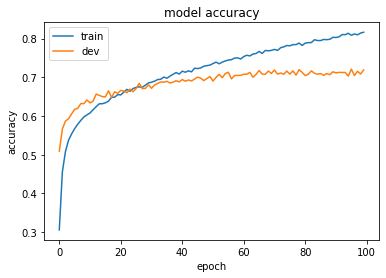

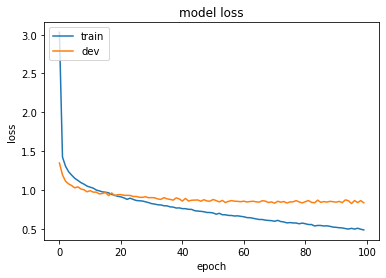

In [ ]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

##### Using Class Weights

In [ ]:
epochs = 50
batch_size = 128
dropout_rate = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
lr = 0.01
decay = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(dropout_rate)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(dropout_rate)(x)
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

resnet_model_cweights = Model(vgg_notop.input, out)

sgd = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=True)
resnet_model_cweights.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])














94699520/94694792 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [ ]:
from sklearn.utils import class_weight
file_stream = file_io.FileIO('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv', mode='r')
data = pd.read_csv(file_stream)
data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
X, Y = data[' pixels'].tolist(), data['emotion'].values
class_weights = class_weight.compute_class_weight('balanced',
                                                    np.unique(Y),
                                                    Y)


In [ ]:
history = resnet_model_cweights.fit_generator( generator = train_generator, validation_data=dev_generator, steps_per_epoch=28709// batch_size, validation_steps=3509 // batch_size, shuffle=True, epochs=epochs, class_weight=class_weights ) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 289s 1s/step - loss: 1.9871 - acc: 0.3442 - val_loss: 1.3152 - val_acc: 0.5000
Epoch 2/100
224/224 [==============================] - 281s 1s/step - loss: 1.3912 - acc: 0.4737 - val_loss: 1.1570 - val_acc: 0.5734
Epoch 3/100
224/224 [==============================] - 280s 1s/step - loss: 1.2821 - acc: 0.5175 - val_loss: 1.1171 - val_acc: 0.5929
Epoch 4/100
224/224 [==============================] - 282s 1s/step - loss: 1.2177 - acc: 0.5430 - val_loss: 1.0938 - val_acc: 0.5875
Epoch 5/100
224/224 [==============================] - 282s 1s/step - loss: 1.1654 - acc: 0.5644 - val_loss: 1.0511 - val_acc: 0.6157
Epoch 6/100
224/224 [==============================] - 282s 1s/step - loss: 1.1429 - acc: 0.5725 - val_loss: 1.0393 - val_acc: 0.6109
Epoch 7/100
224/224 [==============================] - 282s 1s/step - loss: 1.1071 - acc: 0.5876 - v

In [ ]:
print('\n# Evaluate on dev data')
results_dev = resnet_model_cweights.evaluate_generator(dev_generator, 3509 // batch_size)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.8531583790425901, 0.7071759259259259]


In [ ]:
print('\n# Evaluate on test data')
results_test = resnet_model_cweights.evaluate_generator(test_generator, 3509 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.7922037023085134, 0.7239583333333334]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


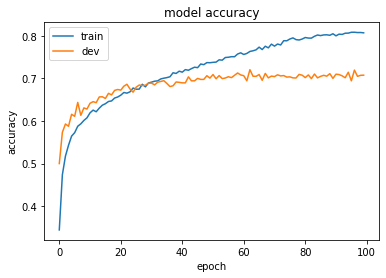

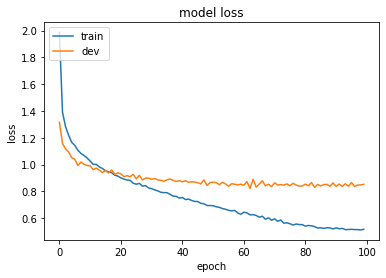

In [ ]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### SeNet50 pretrained Model

In [ ]:
epochs = 100
batch_size = 128
dropout_rate = 0.5
FROZEN_LAYER_NUM = 201
lr = 0.01
decay = 0.0001
Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='senet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(dropout_rate)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(dropout_rate)(x)


batch_norm_indices = [2, 6, 9, 12, 21, 25, 28, 31, 42, 45, 48, 59, 62, 65, 74, 78, 81, 84, 95, 98, 101, 112, 115, 118, 129, 132, 135, 144, 148, 151, 154, 165, 168, 171, 182, 185, 188, 199, 202, 205, 216, 219, 222, 233, 236, 239, 248, 252, 255, 258, 269, 272, 275]    
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False


out = Dense(7, activation='softmax', name='classifier')(x)

senet_model = Model(vgg_notop.input, out)


#optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=True)
#rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

senet_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


104947712/104944616 [==============================] - 1s 0us/step


In [ ]:
history = senet_model.fit_generator( generator = train_generator, validation_data=dev_generator, epochs=epochs,  shuffle=True ) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
238/238 [==============================] - 309s 1s/step - loss: 1.8741 - acc: 0.2840 - val_loss: 1.8226 - val_acc: 0.3435
Epoch 2/100
238/238 [==============================] - 299s 1s/step - loss: 1.4471 - acc: 0.4375 - val_loss: 1.3253 - val_acc: 0.4948
Epoch 3/100
238/238 [==============================] - 294s 1s/step - loss: 1.2316 - acc: 0.5125 - val_loss: 1.1254 - val_acc: 0.5793
Epoch 4/100
238/238 [==============================] - 292s 1s/step - loss: 1.0696 - acc: 0.6065 - val_loss: 1.1040 - val_acc: 0.6057
Epoch 5/100
238/238 [==============================] - 296s 1s/step - loss: 0.9776 - acc: 0.6420 - val_loss: 1.0684 - val_acc: 0.6188
Epoch 6/100
238/238 [==============================] - 296s 1s/step - loss: 0.9207 - acc: 0.6650 - val_loss: 1.0465 - val_acc: 0.6135
Epoch 7/100
238/238 [==============================] - 293s 1s/step - loss: 0.8839 - acc: 0.6780 - v

In [ ]:
print('\n# Evaluate on dev data')
results_dev = senet_model.evaluate_generator(dev_generator, 3509 // batch_size)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [1.9868577674583152, 0.7144097222222222]


In [ ]:
print('\n# Evaluate on test data')
results_test = senet_model.evaluate_generator(test_generator, 3509 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [1.8666118206801239, 0.7254050925925926]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


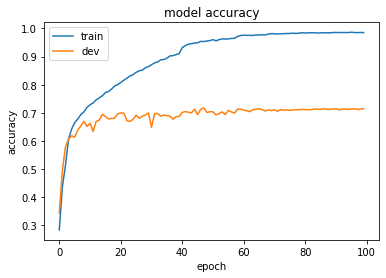

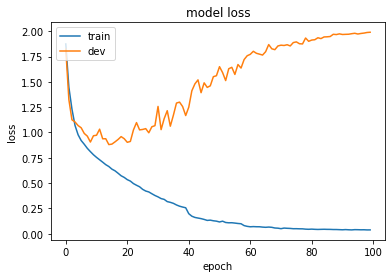

In [ ]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

##### Using Class Weights

In [ ]:
epochs = 100
batch_size = 64
dropout_rate = 0.5
FROZEN_LAYER_NUM = 199

lr = 0.01
decay = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='senet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(dropout_rate)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(dropout_rate)(x)

batch_norm_indices = [2, 6, 9, 12, 21, 25, 28, 31, 42, 45, 48, 59, 62, 65, 74, 78, 81, 84, 95, 98, 101, 112, 115, 118, 129, 132, 135, 144, 148, 151, 154, 165, 168, 171, 182, 185, 188, 199, 202, 205, 216, 219, 222, 233, 236, 239, 248, 252, 255, 258, 269, 272, 275]    
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

senet_model_cweights = Model(vgg_notop.input, out)

sgd = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=True)
senet_model_cweights.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])














104947712/104944616 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [ ]:
from sklearn.utils import class_weight
file_stream = file_io.FileIO('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv', mode='r')
data = pd.read_csv(file_stream)

data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

# Retrieve train input and target
X, Y = data[' pixels'].tolist(), data['emotion'].values

class_weights = class_weight.compute_class_weight('balanced',
                                                    np.unique(Y),
                                                    Y)

In [ ]:
history = senet_model_cweights.fit_generator( generator = train_generator, validation_data=dev_generator,  shuffle=True, epochs=epochs, class_weight=class_weights ) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
238/238 [==============================] - 304s 1s/step - loss: 1.9286 - acc: 0.2698 - val_loss: 1.8309 - val_acc: 0.3062
Epoch 2/100
238/238 [==============================] - 293s 1s/step - loss: 1.5619 - acc: 0.3853 - val_loss: 1.7079 - val_acc: 0.3670
Epoch 3/100
238/238 [==============================] - 290s 1s/step - loss: 1.2920 - acc: 0.5045 - val_loss: 1.2253 - val_acc: 0.5425
Epoch 4/100
238/238 [==============================] - 290s 1s/step - loss: 1.0966 - acc: 0.5979 - val_loss: 1.0938 - val_acc: 0.6138
Epoch 5/100
238/238 [==============================] - 291s 1s/step - loss: 1.0018 - acc: 0.6344 - val_loss: 1.0025 - val_acc: 0.6225
Epoch 6/100
238/238 [==============================] - 290s 1s/step - loss: 0.9410 - acc: 0.6540 - val_loss: 1.0018 - val_acc: 0.6367
Epoch 7/100
238/238 [==============================] - 290s 1s/step - loss: 0.8925 - acc: 0.6747 - v

In [ ]:
print('\n# Evaluate on dev data')
results_dev = senet_model_cweights.evaluate_generator(dev_generator, 3509 // batch_size)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [1.8830583846127544, 0.7135416666666666]


In [ ]:
print('\n# Evaluate on test data')
results_test = senet_model_cweights.evaluate_generator(test_generator, 3509 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [1.8335271411471896, 0.7155671296296297]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


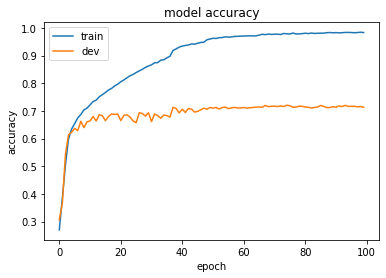

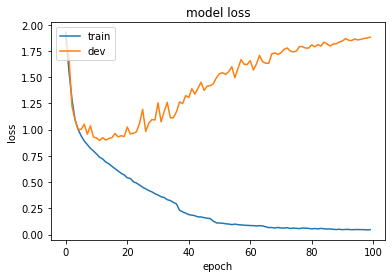

In [ ]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### VGG16 pretrained Model

In [ ]:
epochs = 50
batch_size = 128
dropout_rate = 0.5
FROZEN_LAYER_NUM = 19
lr = 0.01
decay = 0.0001
Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(dropout_rate)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

print(vgg_notop.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)

vgg_model = Model(vgg_notop.input, out)

sgd = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=True)

vgg_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58916864/58909280 [==============================] - 0s 0us/step
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98

In [ ]:
history = vgg_model.fit_generator( generator = train_generator, validation_data=dev_generator,  steps_per_epoch=28709// batch_size, validation_steps=3509 // batch_size, shuffle=True, epochs=epochs) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 267s 1s/step - loss: 1.4812 - acc: 0.4389 - val_loss: 1.1683 - val_acc: 0.5738
Epoch 2/100
224/224 [==============================] - 261s 1s/step - loss: 1.2183 - acc: 0.5448 - val_loss: 1.1045 - val_acc: 0.5914
Epoch 3/100
224/224 [==============================] - 262s 1s/step - loss: 1.1617 - acc: 0.5703 - val_loss: 1.0900 - val_acc: 0.5827
Epoch 4/100
224/224 [==============================] - 263s 1s/step - loss: 1.1333 - acc: 0.5815 - val_loss: 1.0612 - val_acc: 0.6034
Epoch 5/100
224/224 [==============================] - 275s 1s/step - loss: 1.1125 - acc: 0.5880 - val_loss: 1.0419 - val_acc: 0.6163
Epoch 6/100
224/224 [==============================] - 270s 1s/step - loss: 1.0946 - acc: 0.5934 - val_loss: 1.0408 - val_acc: 0.6124
Epoch 7/100
224/224 [==============================] - 275s 1s/step - loss: 1.0659 - acc: 0.6041 - v

In [ ]:
print('\n# Evaluate on dev data')
results_dev = vgg_model.evaluate_generator(dev_generator, 3509 // batch_size)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.9100893073611789, 0.6863425925925926]


In [ ]:
print('\n# Evaluate on test data')
results_test = vgg_model.evaluate_generator(test_generator, 3509 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.8456436241114581, 0.7022569444444444]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


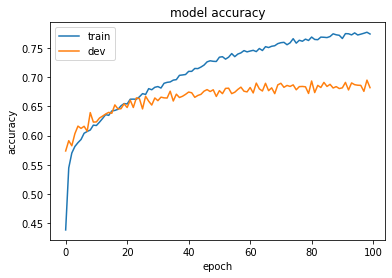

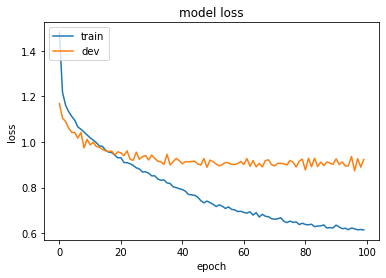

In [ ]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

##### Using Class Weights

In [ ]:
epochs = 100
batch_size = 128
dropout_rate = 0.5
FROZEN_LAYER_NUM = 19
lr = 0.01
decay = 0.0001
Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(dropout_rate)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

print(vgg_notop.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)

vgg_model_cweights = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

vgg_model_cweights.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])





58916864/58909280 [==============================] - 1s 0us/step






Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
____________________________________________

In [ ]:
from sklearn.utils import class_weight
file_stream = file_io.FileIO('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv', mode='r')
data = pd.read_csv(file_stream)
data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
X, Y = data[' pixels'].tolist(), data['emotion'].values
class_weights = class_weight.compute_class_weight('balanced',
                                                    np.unique(Y),
                                                    Y)


In [ ]:
history = vgg_model_cweights.fit_generator( generator = train_generator, validation_data=dev_generator,  steps_per_epoch=28709// batch_size, validation_steps=3509 // batch_size, shuffle=True, epochs=epochs) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
224/224 [==============================] - 284s 1s/step - loss: 1.4781 - acc: 0.4389 - val_loss: 1.1864 - val_acc: 0.5697
Epoch 2/100
224/224 [==============================] - 281s 1s/step - loss: 1.2229 - acc: 0.5462 - val_loss: 1.1079 - val_acc: 0.5995
Epoch 3/100
224/224 [==============================] - 282s 1s/step - loss: 1.1653 - acc: 0.5646 - val_loss: 1.0875 - val_acc: 0.5941
Epoch 4/100
224/224 [==============================] - 278s 1s/step - loss: 1.1312 - acc: 0.5803 - val_loss: 1.0588 - val_acc: 0.6040
Epoch 5/100
224/224 [==============================] - 274s 1s/step - loss: 1.1135 - acc: 0.5852 - val_loss: 1.0577 - val_acc: 0.6064
Epoch 6/100
224/224 [==============================] - 280s 1s/step - loss: 1.0772 - acc: 0.6017 - val_loss: 1.0191 - val_acc: 0.6133
Epoch 7/100
224/224 [==============================] - 279s 1s/step - loss: 1.0729 - acc: 0.6024 - v

In [ ]:
print('\n# Evaluate on dev data')
results_dev = vgg_model_cweights.evaluate_generator(dev_generator, 3509 // batch_size)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.9088092004811322, 0.6805555555555556]


In [ ]:
print('\n# Evaluate on test data')
results_test = vgg_model_cweights.evaluate_generator(test_generator, 3509 // batch_size)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.8557395471466912, 0.6961805555555556]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


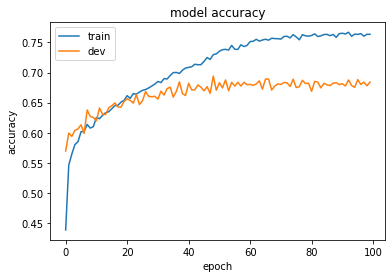

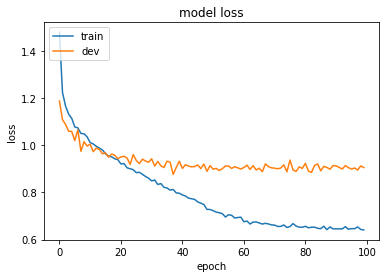

In [ ]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### Ensemble Model

In [ ]:
models = [baseline_model, resnet_model, resnet_model_cweights, vgg_model, vgg_model_cweights, senet_model, senet_model_cweights]

In [ ]:
# Ensemble Classifier
def ensemble_predict(models, X_test):
  yhats = np.zeros((len(models),X_test.shape[0],7))
  for model_ind in range(len(models)):
    yhat = models[model_ind].predict(X_test)
    yhats[len(model_ind),:,:] = yhat
  summed = np.sum(yhats, axis=0)
  result = np.argmax(summed, axis=1)
  return result
 
# evaluate
def evaluate_n_members(models, X_test, y_test):
	yhat = ensemble_predict(models, X_test)
	return accuracy_score(y_test, yhat)

In [ ]:
ens_acc = evaluate_n_members(models, X_test, np.argmax(Y_test, axis=1))
print(ens_acc)

0.7575926441905824
